# Imports

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
from datetime import datetime

# Load and Clean the Data

In [3]:
import pandas as pd

# Load the raw data
def load_and_clean_data(filepath):
    # Read the CSV file and parse the 'Date' column as a DateTime index
    df = pd.read_csv(filepath, parse_dates=["Date"], index_col="Date")
    
    # Check for missing values and handle them
    if df.isnull().sum().any():
        print("Missing values found, filling with forward fill method...")
        df.fillna(method='ffill', inplace=True)
    
    return df

# Example usage
filepath = "../data/raw/BrentOilPrices.csv"
df = load_and_clean_data(filepath)
print(df.head())  # Display the first few rows to verify data

/var/folders/h5/cqk4jd793hzd58k1ssq6mkd40000gn/T/ipykernel_9592/1629603396.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(filepath, parse_dates=["Date"], index_col="Date")


            Price
Date             
1987-05-20  18.63
1987-05-21  18.45
1987-05-22  18.55
1987-05-25  18.60
1987-05-26  18.63


# Exploratory Data Analysis (EDA)

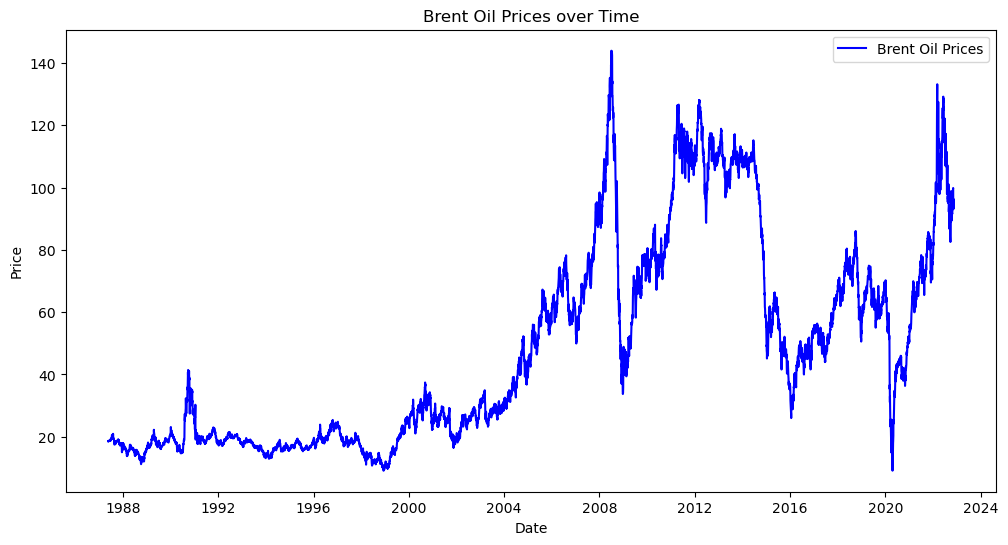


Basic Statistics:
             Price
count  9011.000000
mean     48.420782
std      32.860110
min       9.100000
25%      19.050000
50%      38.570000
75%      70.090000
max     143.950000


In [4]:
import matplotlib.pyplot as plt

# EDA: Visualize the Brent oil prices
def plot_data(df):
    plt.figure(figsize=(12,6))
    plt.plot(df['Price'], label='Brent Oil Prices', color='blue')
    plt.title("Brent Oil Prices over Time")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

# Call the function to plot the data
plot_data(df)

# Display basic statistics of the data
print("\nBasic Statistics:")
print(df.describe())

# Feature Engineering

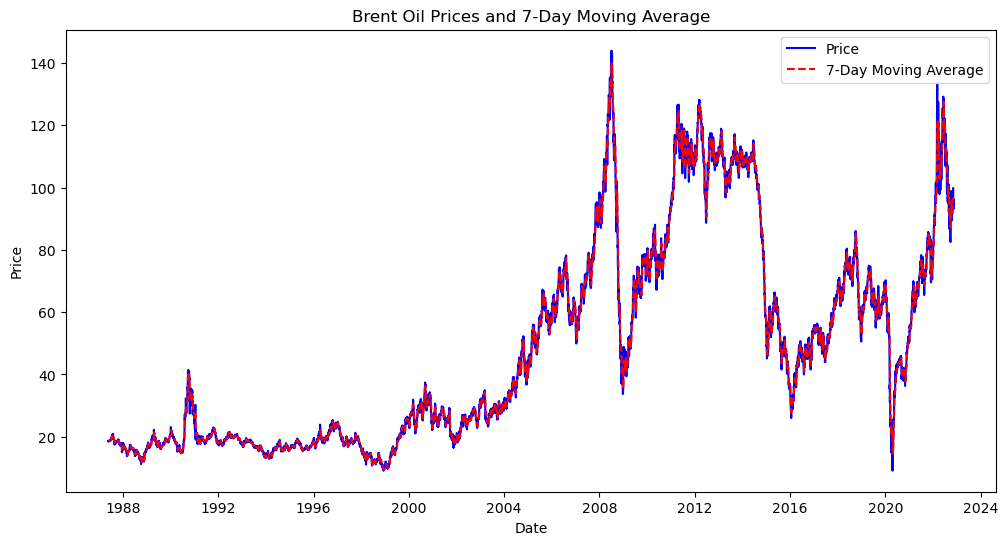


First Few Rows After Feature Engineering:
            Price  7_day_MA  Price_pct_change
Date                                         
1987-05-20  18.63       NaN               NaN
1987-05-21  18.45       NaN         -0.966184
1987-05-22  18.55       NaN          0.542005
1987-05-25  18.60       NaN          0.269542
1987-05-26  18.63       NaN          0.161290


In [5]:
# Feature Engineering: Add moving average and percentage change
def feature_engineering(df):
    # 7-day Moving Average
    df['7_day_MA'] = df['Price'].rolling(window=7).mean()
    
    # Daily Percentage Change
    df['Price_pct_change'] = df['Price'].pct_change() * 100
    
    return df

# Apply feature engineering
df = feature_engineering(df)

# Plot the features
plt.figure(figsize=(12,6))
plt.plot(df['Price'], label="Price", color='blue')
plt.plot(df['7_day_MA'], label="7-Day Moving Average", color='red', linestyle='--')
plt.title("Brent Oil Prices and 7-Day Moving Average")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# Display the first few rows with the new features
print("\nFirst Few Rows After Feature Engineering:")
print(df.head())

#  Model Training (ARIMA and GARCH)

/Users/zelalemtegene/envs/shared_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/zelalemtegene/envs/shared_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/zelalemtegene/envs/shared_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/zelalemtegene/envs/shared_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will 

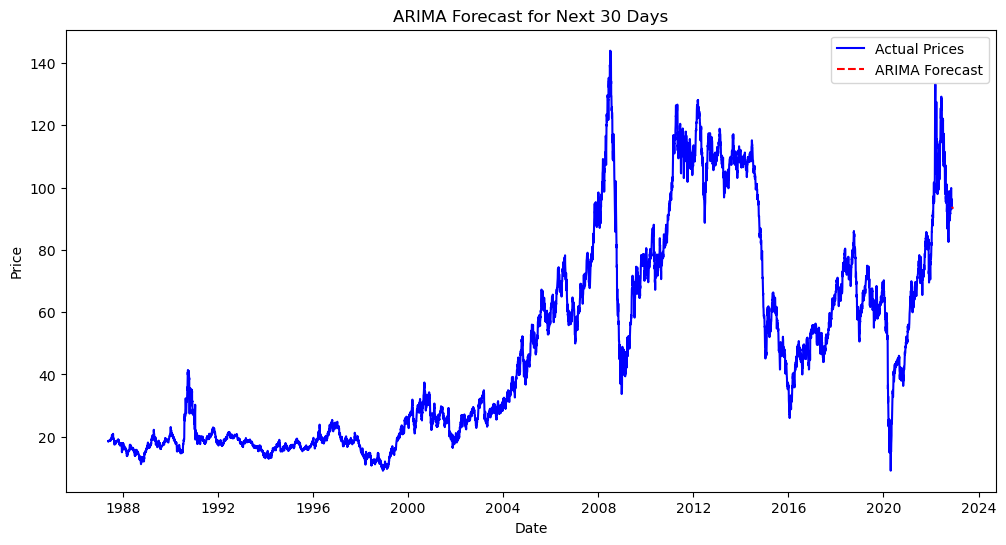


ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 9011
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -14543.950
Date:                Sun, 23 Feb 2025   AIC                          29093.899
Time:                        16:59:33   BIC                          29115.218
Sample:                             0   HQIC                         29101.153
                               - 9011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3427      0.159     -2.152      0.031      -0.655      -0.031
ma.L1          0.3712      0.157      2.358      0.018       0.063       0.680
sigma2         1.4777      0.0

In [6]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA Model: Train and Forecast
def train_arima_model(df):
    # Train the ARIMA model
    arima_model = ARIMA(df['Price'], order=(1,1,1))  # Adjust the order (p, d, q) as needed
    arima_result = arima_model.fit()
    
    # Forecast the next 30 days
    forecast = arima_result.forecast(steps=30)
    
    return arima_result, forecast

# Train ARIMA model and get forecast
arima_result, forecast = train_arima_model(df)

# Plot the forecasted data
plt.figure(figsize=(12,6))
plt.plot(df['Price'], label="Actual Prices", color='blue')
plt.plot(pd.date_range(df.index[-1], periods=31, freq='D')[1:], forecast, label="ARIMA Forecast", color='red', linestyle='--')
plt.title("ARIMA Forecast for Next 30 Days")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# Display ARIMA model summary
print("\nARIMA Model Summary:")
print(arima_result.summary())

#  Model Evaluation and Conclusion

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Model Evaluation
def evaluate_model(df, forecast):
    # Calculate the mean absolute error (MAE) and root mean squared error (RMSE)
    actual = df['Price'].iloc[-30:]  # Last 30 days for evaluation
    mae = mean_absolute_error(actual, forecast)
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")

# Call the function to evaluate the ARIMA model
evaluate_model(df, forecast)

Mean Absolute Error (MAE): 2.0423997444039865
Root Mean Squared Error (RMSE): 2.620176206347034


# Implement GARCH Model

In [ ]:
from arch import arch_model

# GARCH Model: Train and Forecast Volatility
def train_garch_model(df):
    # Fit the GARCH model (using daily returns)
    returns = df['Price_pct_change'].dropna()  # Use percentage change for volatility analysis
    
    garch_model = arch_model(returns, vol='Garch', p=1, q=1)  # p=1, q=1 for GARCH(1, 1)
    garch_result = garch_model.fit(disp="off")
    
    # Forecast the next 30 days of volatility
    forecast_volatility = garch_result.forecast(horizon=30)
    
    return garch_result, forecast_volatility

# Train GARCH model and get volatility forecast
garch_result, forecast_volatility = train_garch_model(df)

# Plot the forecasted volatility
plt.figure(figsize=(12,6))
plt.plot(forecast_volatility.variance.iloc[-1], label="Forecasted Volatility", color='green')
plt.title("Forecasted Volatility (GARCH Model) for Next 30 Days")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

# Display GARCH model summary
print("\nGARCH Model Summary:")
print(garch_result.summary())

# Evaluate GARCH Model

In [ ]:
# Evaluate GARCH model by comparing historical volatility with forecasted volatility
def evaluate_garch_model(df, forecast_volatility):
    # Calculate rolling standard deviation for actual volatility (historical)
    historical_volatility = df['Price_pct_change'].rolling(window=30).std()
    
    # Plot historical vs forecasted volatility
    plt.figure(figsize=(12,6))
    plt.plot(historical_volatility, label="Historical Volatility", color='blue')
    plt.plot(forecast_volatility.variance.iloc[-1], label="Forecasted Volatility", color='red', linestyle='--')
    plt.title("Historical vs Forecasted Volatility (GARCH Model)")
    plt.xlabel("Date")
    plt.ylabel("Volatility")
    plt.legend()
    plt.show()

# Call the evaluation function
evaluate_garch_model(df, forecast_volatility)

# Summarizing Results and Conclusion

In [ ]:
# Summary of results
def summarize_results(arima_result, garch_result):
    print("\n--- ARIMA Model Summary ---")
    print(arima_result.summary())
    print("\n--- GARCH Model Summary ---")
    print(garch_result.summary())

# Call the summary function
summarize_results(arima_result, garch_result)